In [1]:
from hyperopt import tpe, hp, fmin, space_eval, Trials

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

# Datasets
from sklearn.datasets import load_boston, load_iris

# Regression Models
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

# Classification Models
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

CV Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

HyperOpt: https://github.com/hyperopt/hyperopt/wiki/FMin

In [2]:
N_SPLITS = 5 # for cross validation

In [3]:
def objective_func(params):
    for param_name in params['int_param_names']:
        params['params'][param_name] = int(params['params'][param_name])
    
    estim = params['model'](**params['params'])
    
    score = cross_val_score(estim, 
                            x_train, 
                            y_train, 
                            scoring=CV_SCORING_METRIC, 
                            cv=CV(n_splits=N_SPLITS, 
                                     shuffle=True, 
                                     random_state=0)).mean()

    return -score if IS_HIGHER_BETTER else score

In [4]:
# max_evals -> of hyperopt optimization rounds
def get_best_estimator(max_evals=100):
    trials = Trials()
    best_estimator = fmin(objective_func,
                           space,
                           algo=tpe.suggest,
                           max_evals=max_evals,
                           trials=trials,
                           rstate=np.random.RandomState(0))
    
    model = space_eval(space, best_estimator)['model']
    params = space_eval(space, best_estimator)['params']

    estimator = model(**params)
    
    return estimator, trials

# Regression

In [5]:
x, y = load_boston(return_X_y=True)

In [6]:
CV_SCORING_METRIC = 'neg_mean_squared_error'
IS_HIGHER_BETTER = True # this will add '-' (minus) to the loss as we have 'NEG' in 'neg_mean_squared_error'
                        # because hyperopt tries to MINIMIZE objective function
CV = KFold

In [7]:
space = hp.choice('estimator',
        [
            {'model': LGBMRegressor,
             'params': {
                        'objective' : hp.choice('objective_LGBM', ['regression']),
                        'metric' : hp.choice('metric_LGBM', ['mse']),
                        'n_jobs' : hp.choice('n_jobs_LGBM', [3]),
                        'random_state' : hp.choice('random_state_LGBM', [0]),

                        'colsample_bytree' : hp.uniform('colsample_bytree_LGBM', 0.2, 0.8),
                        'learning_rate' : hp.uniform('learning_rate_LGBM', 0.001, 0.5),
                        'subsample' : hp.uniform('subsample_LGBM', 0.2, 0.8),

                        'max_depth' : hp.quniform('max_depth_LGBM', 2, 9, 1), # 1 stands for q
                        'n_estimators' : hp.quniform('n_estimators_LGBM', 50, 500, 1)
                      },
             'int_param_names' : ['max_depth', 'n_estimators']
            },

            {'model': Ridge,
             'params': {
                           'normalize' : hp.choice('normalize_RIDGE', [True, False]),
                           'solver' : hp.choice('solver_RIDGE', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
                           'random_state' : hp.choice('random_state_RIDGE', [0]),

                           'alpha' : hp.loguniform('alpha_RIDGE', -5, 5)
                      },
             'int_param_names' : []
        }
        ])
# Labels should have unique names (i.e. if we put simply 'random_state' in both LGBMRegressor and Ridge -> error)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

estimator, _ = get_best_estimator()
estimator

100%|██████████| 100/100 [00:15<00:00,  5.68it/s, best loss: 8.392130215229862]


LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.7182480942124142, importance_type='split',
              learning_rate=0.16040147643869565, max_depth=4.0, metric='mse',
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=358.0, n_jobs=3, num_leaves=31,
              objective='regression', random_state=0, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.7030235795002958,
              subsample_for_bin=200000, subsample_freq=0)

# Classification

In [9]:
x, y = load_iris(return_X_y=True)

In [10]:
CV_SCORING_METRIC = 'balanced_accuracy'
IS_HIGHER_BETTER = True # this will add '-' (minus) to the loss as we have 'NEG' in 'neg_mean_squared_error'
                        # because hyperopt tries to MINIMIZE objective function
CV = StratifiedKFold

In [11]:
space = hp.choice('estimator',
        [
            {'model': LGBMClassifier,
             'params': {
                        'objective' : hp.choice('objective_LGBM', ['multiclass']),
                        'metric' : hp.choice('metric_LGBM', ['multi_logloss']),
                        'n_jobs' : hp.choice('n_jobs_LGBM', [3]),
                        'random_state' : hp.choice('random_state_LGBM', [0]),

                        'colsample_bytree' : hp.uniform('colsample_bytree_LGBM', 0.2, 0.8),
                        'learning_rate' : hp.uniform('learning_rate_LGBM', 0.001, 0.5),
                        'subsample' : hp.uniform('subsample_LGBM', 0.2, 0.8),

                        'max_depth' : hp.quniform('max_depth_LGBM', 2, 9, 1), # 1 stands for q
                        'n_estimators' : hp.quniform('n_estimators_LGBM', 50, 500, 1)
                      },
             'int_param_names' : ['max_depth', 'n_estimators']
            },

            {'model': SVC,
             'params': {
                       'C'      : hp.lognormal('C_SVC', 0,1),
                       'kernel' : hp.choice('kernel_SVC', ['rbf', 'poly', 'rbf', 'sigmoid']),
                       'degree' : hp.choice('degree_SVC', range(1,15)),
                       'gamma'  : hp.uniform('gamma_SVC', 0.001,10000)
                      },
             'int_param_names' : []
        }
        ])
# Labels should have unique names (i.e. if we put simply 'random_state' in both LGBMRegressor and Ridge -> error)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

estimator, _ = get_best_estimator()
estimator

100%|██████████| 100/100 [00:14<00:00,  5.07it/s, best loss: -0.9580687830687831]


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6362652862491109, importance_type='split',
               learning_rate=0.49849818403162566, max_depth=5.0,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=349.0,
               n_jobs=3, num_leaves=31, objective='multiclass', random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.45608066870051306, subsample_for_bin=200000,
               subsample_freq=0)

# Visualizing

In [13]:
import matplotlib.pyplot as plt

In [14]:
x, y = load_iris(return_X_y=True)

In [15]:
CV_SCORING_METRIC = 'balanced_accuracy'
IS_HIGHER_BETTER = True # this will add '-' (minus) to the loss as we have 'NEG' in 'neg_mean_squared_error'
                        # because hyperopt tries to MINIMIZE objective function
CV = StratifiedKFold

In [16]:
space = hp.choice('estimator',
        [
            {'model': LGBMClassifier,
             'params': {
                        'objective' : hp.choice('objective_LGBM', ['multiclass']),
                        'metric' : hp.choice('metric_LGBM', ['multi_logloss']),
                        'n_jobs' : hp.choice('n_jobs_LGBM', [3]),
                        'random_state' : hp.choice('random_state_LGBM', [0]),

                        'colsample_bytree' : hp.uniform('colsample_bytree_LGBM', 0.2, 0.8),
                        'learning_rate' : hp.uniform('learning_rate_LGBM', 0.001, 0.5),
                        'subsample' : hp.uniform('subsample_LGBM', 0.2, 0.8),

                        'max_depth' : hp.quniform('max_depth_LGBM', 2, 9, 1), # 1 stands for q
                        'n_estimators' : hp.quniform('n_estimators_LGBM', 50, 500, 1)
                      },
             'int_param_names' : ['max_depth', 'n_estimators']
            }
        ])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

estimator, trials = get_best_estimator(max_evals=1000)
estimator

100%|██████████| 1000/1000 [02:48<00:00,  5.73it/s, best loss: -0.9738095238095239]


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5511401477986821, importance_type='split',
               learning_rate=0.0040840522922409046, max_depth=3.0,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=203.0,
               n_jobs=3, num_leaves=31, objective='multiclass', random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.524014243099493, subsample_for_bin=200000,
               subsample_freq=0)

In [18]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.9414021164021165, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree_LGBM': [0],
    'estimator': [0],
    'learning_rate_LGBM': [0],
    'max_depth_LGBM': [0],
    'metric_LGBM': [0],
    'n_estimators_LGBM': [0],
    'n_jobs_LGBM': [0],
    'objective_LGBM': [0],
    'random_state_LGBM': [0],
    'subsample_LGBM': [0]},
   'vals': {'colsample_bytree_LGBM': [0.5500470040901745],
    'estimator': [0],
    'learning_rate_LGBM': [0.09860260867094904],
    'max_depth_LGBM': [9.0],
    'metric_LGBM': [0],
    'n_estimators_LGBM': [359.0],
    'n_jobs_LGBM': [0],
    'objective_LGBM': [0],
    'random_state_LGBM': [0],
    'subsample_LGBM': [0.4916283938129303]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 6, 29, 0, 55, 9, 510000),
  'refresh_time': datetime.datetime(2019, 6, 29, 0, 55, 9, 7

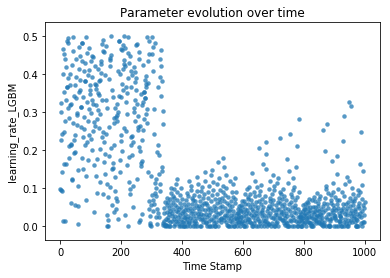

In [19]:
f, ax = plt.subplots(1)

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['learning_rate_LGBM'] for t in trials.trials]

ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

ax.set_title('Parameter evolution over time')
ax.set_xlabel('Time Stamp')
ax.set_ylabel('learning_rate_LGBM')

plt.show()

As you can see, at the beginning of optimization the learning_rate parameter was sampled from a wider range than later.

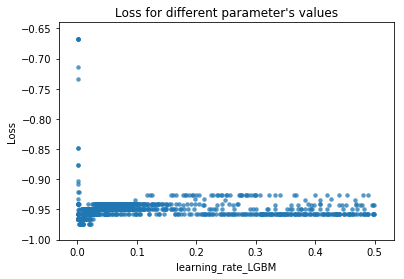

In [20]:
f, ax = plt.subplots(1)

xs = [t['misc']['vals']['learning_rate_LGBM'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]

ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

ax.set_title('Loss for different parameter\'s values')
ax.set_xlabel('learning_rate_LGBM')
ax.set_ylabel('Loss')

plt.show()